In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, AutoETS

from sklearn.metrics import mean_squared_error

In [12]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [13]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["ds"] = pdf.index
pdf["unique_id"] = "test"
pdf = pdf.reset_index(drop=True)

pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_14736\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,ds,unique_id,y
0,2015-01-01,test,6.709087
1,2015-01-02,test,7.073348
2,2015-01-03,test,7.149544
3,2015-01-04,test,6.724467
4,2015-01-05,test,8.585045
...,...,...,...
3087,2023-06-15,test,7.271072
3088,2023-06-16,test,7.173852
3089,2023-06-17,test,6.233946
3090,2023-06-18,test,5.879637


In [16]:
#season_length/cycles of the time series are weekly and yearly yearly
mstl = MSTL(season_length=[7, 365])  #  trend_forecaster=AutoETS(), AutoARIMA()         
model = StatsForecast(models = [mstl], freq = 'D')
model.fit(pdf_train)

StatsForecast(models=[MSTL])

In [17]:
y_pred = model.predict(h=len(pdf_test)) 
y_pred.tail()

,ds,MSTL
unique_id,,
test,2023-06-15,7.498631
test,2023-06-16,7.679181
test,2023-06-17,6.672068
test,2023-06-18,6.312647
test,2023-06-19,7.251018


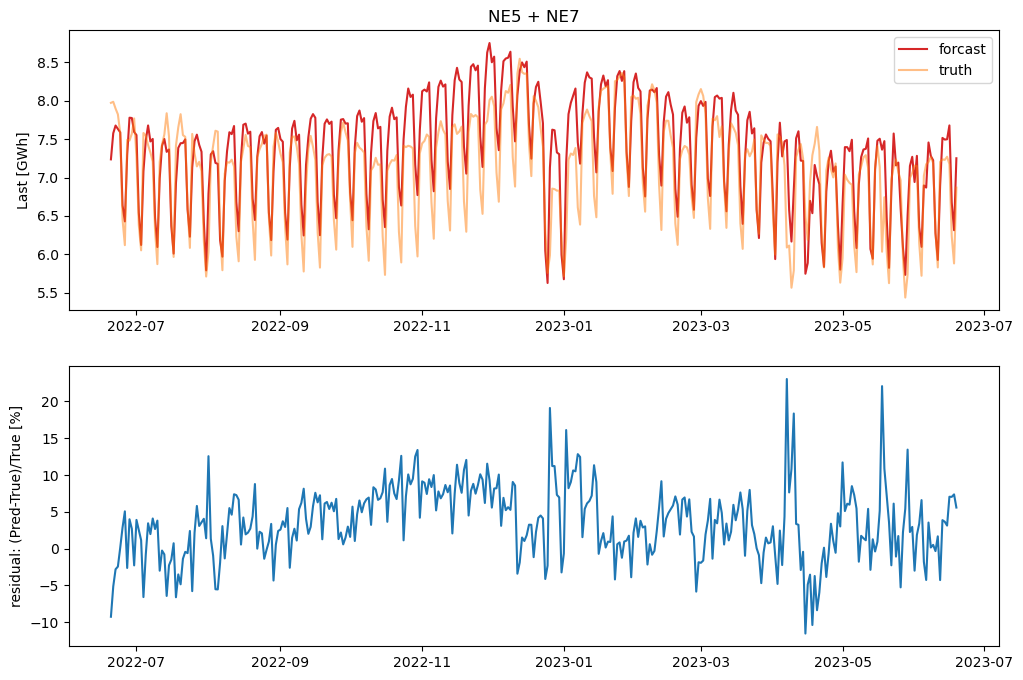

In [18]:

f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(y_pred.ds.values, y_pred.MSTL, color="tab:red", label="forcast")
# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test.ds.values, pdf_test.y.values, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.ds, (y_pred.MSTL - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")


plt.show()

In [19]:
rmseValue = mean_squared_error(pdf_test.y, y_pred.MSTL, squared=False)
rmseValue

0.4102673105484932

In [20]:
model.fitted_[0, 0].model_

,data,trend,seasonal7,seasonal365,remainder
0,6.709087,7.830946,-0.131345,-0.754480,-0.236034
1,7.073348,7.830519,-0.002452,-0.448964,-0.305755
2,7.149544,7.830092,-0.710797,-0.167962,0.198211
3,6.724467,7.829664,-1.124907,0.097440,-0.077731
4,8.585046,7.829237,0.626019,0.139801,-0.010010
...,...,...,...,...,...
2722,7.643969,7.512705,0.479333,-0.221567,-0.126503
2723,7.817915,7.513603,0.360609,-0.061518,0.005221
2724,7.643866,7.514502,0.381109,-0.105354,-0.146391
2725,6.660742,7.515400,-0.582168,-0.090469,-0.182020


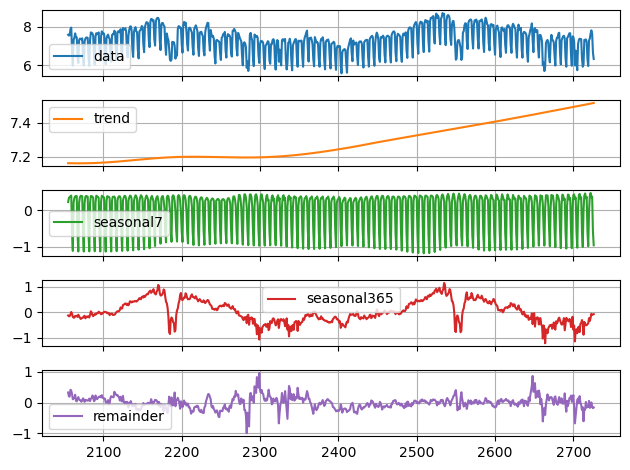

In [ ]:
model.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

In [ ]:
#Give a name to the run. Under this name the search will be grouped.
#Coudl you rewrite this sentece? 
#The name is used to group the search results.